#🌍 CO₂ Emissions & Energy Use

## Introduction


**Objective:** Analyze global CO₂ emissions and energy use over time.

**Tools:** SQL for querying, Python (Pandas + Matplotlib) for visualization.

**Datasets:**
owid-co2-data.csv
owid-energy-data.csv

In [2]:
# Environment Setup

# Install SQL magic for Colab
!pip install ipython-sql==0.5.0 prettytable==3.3.0

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [3]:
#Load the Extension
%load_ext sql

In [4]:
# Create SQLite database "co2"
%sql sqlite:///co2.db

In [5]:
# Load Data into Database
# Upload files first in Colab sidebar (or mount Google Drive)

co2 = pd.read_csv("/content/owid-co2-data.csv")
energy = pd.read_csv("/content/owid-energy-data.csv")


## Data inspection

In [6]:
# Quick look at first 5 rows
print(co2.head())


       country  year iso_code  population  gdp  cement_co2  \
0  Afghanistan  1750      AFG   2802560.0  NaN         0.0   
1  Afghanistan  1751      AFG         NaN  NaN         0.0   
2  Afghanistan  1752      AFG         NaN  NaN         0.0   
3  Afghanistan  1753      AFG         NaN  NaN         0.0   
4  Afghanistan  1754      AFG         NaN  NaN         0.0   

   cement_co2_per_capita  co2  co2_growth_abs  co2_growth_prct  ...  \
0                    0.0  NaN             NaN              NaN  ...   
1                    NaN  NaN             NaN              NaN  ...   
2                    NaN  NaN             NaN              NaN  ...   
3                    NaN  NaN             NaN              NaN  ...   
4                    NaN  NaN             NaN              NaN  ...   

   share_global_other_co2  share_of_temperature_change_from_ghg  \
0                     NaN                                   NaN   
1                     NaN                                   NaN   

In [7]:
# Summary of columns and data types
print(co2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50191 entries, 0 to 50190
Data columns (total 79 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   country                                    50191 non-null  object 
 1   year                                       50191 non-null  int64  
 2   iso_code                                   42262 non-null  object 
 3   population                                 41019 non-null  float64
 4   gdp                                        15251 non-null  float64
 5   cement_co2                                 28863 non-null  float64
 6   cement_co2_per_capita                      25358 non-null  float64
 7   co2                                        29137 non-null  float64
 8   co2_growth_abs                             26981 non-null  float64
 9   co2_growth_prct                            26002 non-null  float64
 10  co2_including_luc     

In [8]:
# Check if there are any missing values
print(co2.isnull().sum().head(15))  # show first 15 columns for quick check

country                              0
year                                 0
iso_code                          7929
population                        9172
gdp                              34940
cement_co2                       21328
cement_co2_per_capita            24833
co2                              21054
co2_growth_abs                   23210
co2_growth_prct                  24189
co2_including_luc                26606
co2_including_luc_growth_abs     26906
co2_including_luc_growth_prct    26906
co2_including_luc_per_capita     26696
co2_including_luc_per_gdp        33401
dtype: int64


# 🧹 Clean Dataset

In [9]:
# Drop duplicates (if any)
co2 = co2.drop_duplicates()

### Keep data only from 1950 onwards
Becayse it looks complete and reliable after 1950 and the plots look cleaner (no huge empty gaps at the start)

In [10]:
# Keep only data from 1950 onwards
co2_clean = co2[co2['year'] >= 1950]

# Reset index again
co2_clean = co2_clean.reset_index(drop=True)

print(co2_clean.head())
print(co2_clean['year'].min())  # should show 1950 now

       country  year iso_code  population           gdp  cement_co2  \
0  Afghanistan  1950      AFG   7776182.0  9.421400e+09         0.0   
1  Afghanistan  1951      AFG   7879343.0  9.692280e+09         0.0   
2  Afghanistan  1952      AFG   7987783.0  1.001733e+10         0.0   
3  Afghanistan  1953      AFG   8096703.0  1.063052e+10         0.0   
4  Afghanistan  1954      AFG   8207953.0  1.086636e+10         0.0   

   cement_co2_per_capita    co2  co2_growth_abs  co2_growth_prct  ...  \
0                    0.0  0.084           0.070          475.000  ...   
1                    0.0  0.092           0.007            8.696  ...   
2                    0.0  0.092           0.000            0.000  ...   
3                    0.0  0.106           0.015           16.000  ...   
4                    0.0  0.106           0.000            0.000  ...   

   share_global_other_co2  share_of_temperature_change_from_ghg  \
0                     NaN                                 0.128   


### 👉 Filter Country Names.
The dataset has both real countries (India, China, USA) and aggregates/regions (World, Asia, OECD, Non-OECD, income groups). Therefore, the “Top Emitters” chart will include regions instead of only countries.

To fix this I'll filter the Country Names.

In OWID’s datasets, real countries are listed with ISO country codes (like IND, CHN, USA) in the column iso_code. Aggregates like World, Asia, OECD have iso_code = "" (empty) or something special. So we keep only rows with 3-letter ISO codes.

In [11]:


# Keep only rows where iso_code has exactly 3 characters (countries)
co2_clean = co2_clean[co2_clean['iso_code'].str.len() == 3]

# Drop rows with missing country names
co2_clean = co2_clean.dropna(subset=['country'])

# Reset index for neatness
co2_clean = co2_clean.reset_index(drop=True)

# Check cleaned dataset
print(co2_clean.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16132 entries, 0 to 16131
Data columns (total 79 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   country                                    16132 non-null  object 
 1   year                                       16132 non-null  int64  
 2   iso_code                                   16132 non-null  object 
 3   population                                 15984 non-null  float64
 4   gdp                                        11457 non-null  float64
 5   cement_co2                                 14600 non-null  float64
 6   cement_co2_per_capita                      14512 non-null  float64
 7   co2                                        15055 non-null  float64
 8   co2_growth_abs                             14952 non-null  float64
 9   co2_growth_prct                            14895 non-null  float64
 10  co2_including_luc     

In [12]:
co2_clean.to_csv("co2_countries.csv", index=False)
print("✅ Cleaned dataset saved as co2_countries.csv")



✅ Cleaned dataset saved as co2_countries.csv


# Load Cleaned CSV into SQLite 🛢⛁

In [13]:
# Connect using sqlite3
conn = sqlite3.connect("co2.db")

# Load cleaned CSV into a SQL table
co2_clean = pd.read_csv("co2_countries.csv")
co2_clean.to_sql("co2", conn, if_exists="replace", index=False)


16132

## 📊 Global CO₂ Trend Since 1950

In [14]:
# SQL Analysis

%%sql
SELECT year, round(SUM(co2),2) AS total_co2_emission
FROM co2
GROUP BY year
ORDER BY year;


 * sqlite:///co2.db
Done.


year,total_co2_emission
1950,5801.86
1951,6228.25
1952,6311.31
1953,6488.79
1954,6626.84
1955,7256.81
1956,7724.79
1957,7961.96
1958,8209.29
1959,8641.32


# 📊 Global CO₂ Trend Since 1950 👀

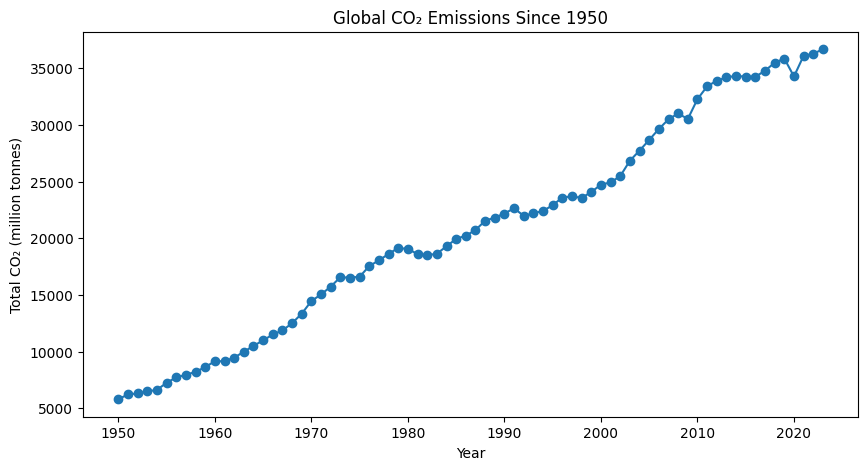

In [15]:
# Visualization in Python

global_co2 = pd.read_sql("""
    SELECT year, SUM(co2) AS total_co2
    FROM co2
    GROUP BY year
    ORDER BY year
""", conn)

plt.figure(figsize=(10,5))
plt.plot(global_co2["year"], global_co2["total_co2"], marker="o")
plt.title("Global CO₂ Emissions Since 1950")
plt.xlabel("Year")
plt.ylabel("Total CO₂ (million tonnes)")
plt.show()

# 📶 Top 10 Emitters in 2023

In [16]:
%%sql
SELECT country, co2
FROM co2
WHERE year = 2023
ORDER BY co2 DESC
LIMIT 10;


 * sqlite:///co2.db
Done.


country,co2
China,11902.503
United States,4911.391
India,3062.324
Russia,1815.925
Japan,988.785
Iran,817.88
Saudi Arabia,736.205
Indonesia,733.224
Germany,596.151
South Korea,577.417


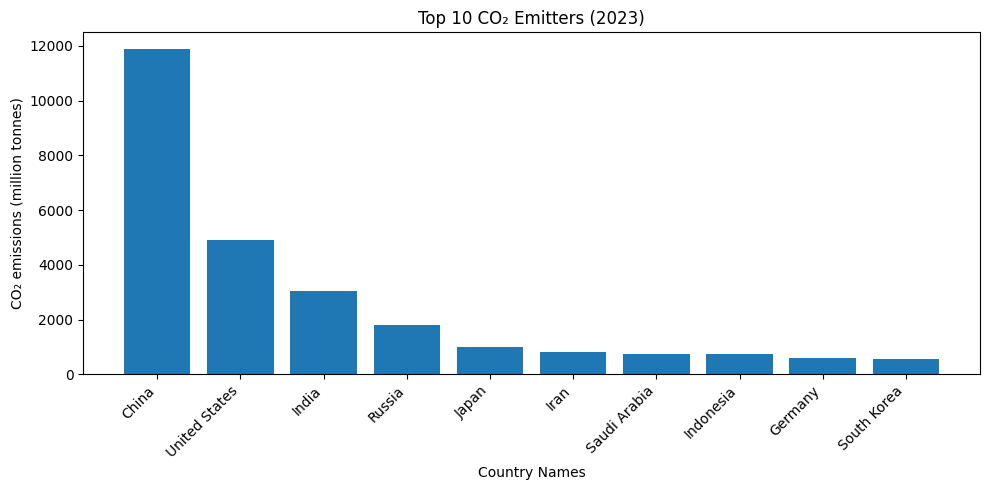

In [17]:
#Visualization in Python

top_emitters = pd.read_sql("""
    SELECT country, co2
    FROM co2
    WHERE year = 2023
    ORDER BY co2 DESC
    LIMIT 10
""", conn)

plt.figure(figsize=(10,5))
plt.bar(top_emitters["country"], top_emitters["co2"])
plt.title("Top 10 CO₂ Emitters (2023)")
plt.ylabel("CO₂ emissions (million tonnes)")
plt.xlabel("Country Names")
plt.xticks(rotation=45, ha="right")   # ha - fixed alignment
plt.tight_layout()

plt.show()


# 📑Energy vs CO₂ (Join Tables for 2020)

In [18]:
%%sql
SELECT c.country, c.year, c.co2, e.primary_energy_consumption
FROM co2 c
JOIN energy e
ON c.country = e.country AND c.year = e.year
WHERE c.year = 2020;


 * sqlite:///co2.db
(sqlite3.OperationalError) no such table: energy
[SQL: SELECT c.country, c.year, c.co2, e.primary_energy_consumption
FROM co2 c
JOIN energy e
ON c.country = e.country AND c.year = e.year
WHERE c.year = 2020;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


# Energy vs CO₂ Scatter 📉

In [ ]:
scatter = pd.read_sql("""
    SELECT c.country, c.co2, e.primary_energy_consumption
    FROM co2 c
    JOIN energy e
    ON c.country = e.country AND c.year = e.year
    WHERE c.year = 2020
""", conn)

plt.figure(figsize=(8,6))
plt.scatter(scatter["primary_energy_consumption"], scatter["co2"], alpha=0.6)
plt.title("Energy Consumption vs CO₂ Emissions (2020)")
plt.xlabel("Primary Energy Consumption")
plt.ylabel("CO₂ Emissions")
plt.show()


# 📌 Insights

*   Global CO₂ emissions have increased sharply since 1950.
*   China, USA, and India are top emitters in 2021.
*   Higher energy use generally leads to higher CO₂, but some countries show better efficiency.
*  Renewable adoption may explain differences.






# India-Focused KPIs and Trends 🇮🇳

## India’s CO₂ Trend Over Time


In [20]:
%%sql
SELECT year, co2
FROM co2
WHERE country = 'India'
ORDER BY year;


 * sqlite:///co2.db
Done.


year,co2
1950,61.103
1951,64.022
1952,67.426
1953,68.705
1954,72.414
1955,78.788
1956,81.656
1957,91.635
1958,95.816
1959,101.447


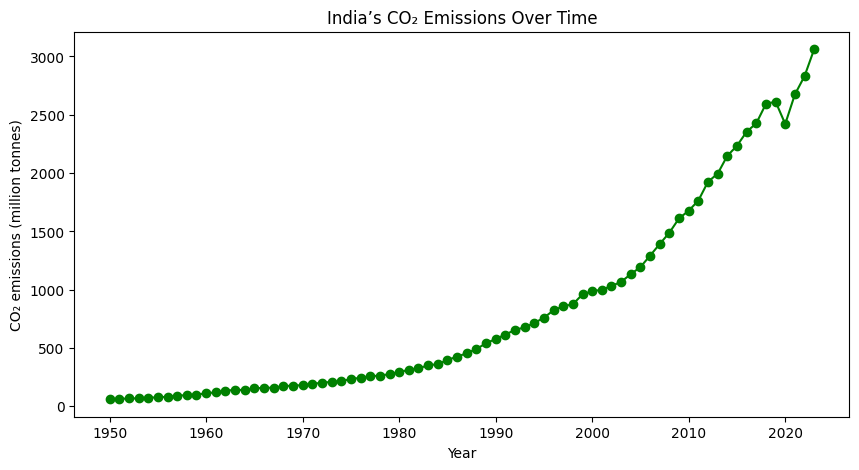

In [21]:
india_co2 = pd.read_sql("""
    SELECT year, co2
    FROM co2
    WHERE country = 'India'
    ORDER BY year
""", conn)

plt.figure(figsize=(10,5))
plt.plot(india_co2["year"], india_co2["co2"], marker="o", color="green")
plt.title("India’s CO₂ Emissions Over Time")
plt.xlabel("Year")
plt.ylabel("CO₂ emissions (million tonnes)")
plt.show()


## Per Capita CO₂ Emissions for India

In [22]:
%%sql
SELECT year, co2_per_capita
FROM co2
WHERE country = 'India'
ORDER BY year;


 * sqlite:///co2.db
Done.


year,co2_per_capita
1950,0.176
1951,0.181
1952,0.186
1953,0.186
1954,0.191
1955,0.203
1956,0.206
1957,0.226
1958,0.23
1959,0.238


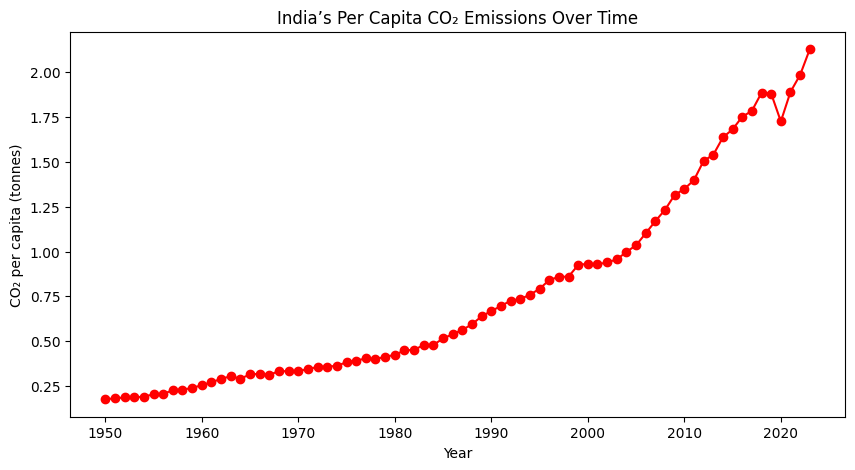

In [23]:
india_percapita = pd.read_sql("""
    SELECT year, co2_per_capita
    FROM co2
    WHERE country = 'India'
    ORDER BY year
""", conn)

plt.figure(figsize=(10,5))
plt.plot(india_percapita["year"], india_percapita["co2_per_capita"], marker="o", color="red")
plt.title("India’s Per Capita CO₂ Emissions Over Time")
plt.xlabel("Year")
plt.ylabel("CO₂ per capita (tonnes)")
plt.show()


## India’s Energy Consumption vs CO₂

In [ ]:
%%sql
SELECT c.year, c.co2, e.primary_energy_consumption
FROM co2 c
JOIN energy e
ON c.country = e.country AND c.year = e.year
WHERE c.country = 'India'
ORDER BY c.year;


In [ ]:
india_energy = pd.read_sql("""
    SELECT c.year, c.co2, e.primary_energy_consumption
    FROM co2 c
    JOIN energy e
    ON c.country = e.country AND c.year = e.year
    WHERE c.country = 'India'
    ORDER BY c.year
""", conn)

plt.figure(figsize=(10,5))
plt.plot(india_energy["year"], india_energy["co2"], label="CO₂ emissions")
plt.plot(india_energy["year"], india_energy["primary_energy_consumption"], label="Energy consumption")
plt.title("India: Energy Consumption vs CO₂ Emissions")
plt.xlabel("Year")
plt.ylabel("Values (scaled)")
plt.legend()
plt.show()


## India’s Share in Global Emissions

In [26]:
%%sql
SELECT c.year,
       c.co2 * 100.0 / g.total_co2 AS india_share
FROM co2 c
JOIN (
    SELECT year, SUM(co2) AS total_co2
    FROM co2
    GROUP BY year
) g
ON c.year = g.year
WHERE c.country = 'India'
ORDER BY c.year;


 * sqlite:///co2.db
Done.


year,india_share
1950,1.05316298784389
1951,1.027928863507771
1952,1.0683367277707656
1953,1.0588260677260324
1954,1.0927386764965967
1955,1.0857115139328473
1956,1.05706392391356
1957,1.1509099328670416
1958,1.1671653496020555
1959,1.1739754634765378


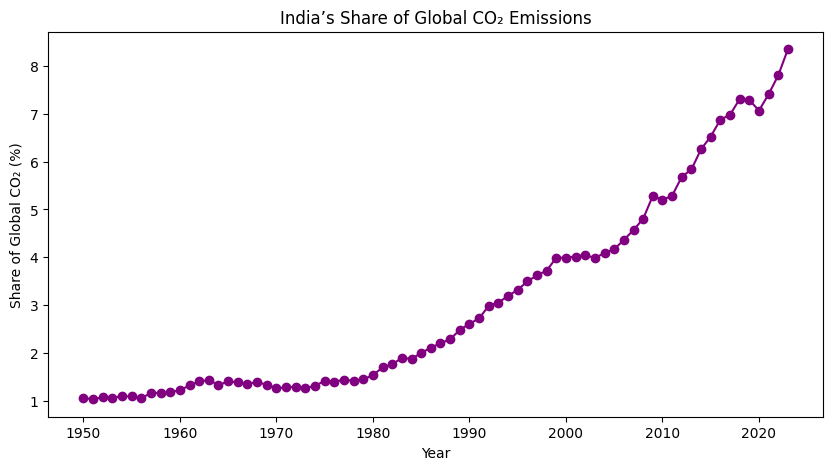

In [27]:
india_share = pd.read_sql("""
    SELECT c.year,
           c.co2 * 100.0 / g.total_co2 AS india_share
    FROM co2 c
    JOIN (
        SELECT year, SUM(co2) AS total_co2
        FROM co2
        GROUP BY year
    ) g
    ON c.year = g.year
    WHERE c.country = 'India'
    ORDER BY c.year
""", conn)

plt.figure(figsize=(10,5))
plt.plot(india_share["year"], india_share["india_share"], color="purple", marker="o")
plt.title("India’s Share of Global CO₂ Emissions")
plt.xlabel("Year")
plt.ylabel("Share of Global CO₂ (%)")
plt.show()
